# **Sleep, Lifestyle, and Health of Professionals and Students Data Science**
Project by Team Sleeping On It: *Ishaan Adhikary, Aarav Gadkar, Justin Ma, Mohammed Umar*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Data Preparation and Feature Engineering

In [2]:
url_stem = "https://raw.githubusercontent.com/gaminghusky1/DataScienceProject/main/"

In [3]:
efficiency_df_raw = pd.read_csv(url_stem + "Sleep_Efficiency.csv")

In [4]:
efficiency_df_raw.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


For this dataset, only three simple changes need to be made. The first is to set the index to the `ID`, as this is the most logical index for the dataset. The second is to remove the date information from `Bedtime` and `Wakeup time`, as each column represents the typical bedtime and wakeup time for each participant. The exact date on which the data was recorded does not matter for our purposes. Finally, we should rename `Gender` to `Sex` to better represent the meaning of the data and ensure consistency across dataframes.

In [5]:
def strip_date(input):
  bedtime = pd.Timestamp(input['Bedtime']).strftime('%X')
  wakeup = pd.Timestamp(input['Wakeup time']).strftime('%X')
  return [bedtime, wakeup]

efficiency_df = efficiency_df_raw.copy()
efficiency_df[['Bedtime', 'Wakeup time']] = efficiency_df_raw.apply(
    strip_date, axis = 'columns', result_type = 'expand')
efficiency_df = efficiency_df.set_index('ID').rename(
    {'Gender' : 'Sex'}, axis = 'columns')
efficiency_df.head()

,Age,Sex,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
ID,,,,,,,,,,,,,,
1,65,Female,01:00:00,07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
2,69,Male,02:00:00,09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
3,40,Female,21:30:00,05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
4,40,Female,02:30:00,08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
5,57,Male,01:00:00,09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


# Question 1 - Understanding the data
Can we calculate a numeric sleep score using a formula that takes into account the sleep duration, efficiency, and proportions of sleep in each stage (light, deep, REM)?


In [6]:
efficiency_df

,Age,Sex,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
ID,,,,,,,,,,,,,,
1,65,Female,01:00:00,07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
2,69,Male,02:00:00,09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
3,40,Female,21:30:00,05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
4,40,Female,02:30:00,08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
5,57,Male,01:00:00,09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,27,Female,22:00:00,05:30:00,7.5,0.91,22,57,21,0.0,0.0,0.0,No,5.0
449,52,Male,21:00:00,03:00:00,6.0,0.74,28,57,15,4.0,25.0,0.0,No,3.0
450,40,Female,23:00:00,07:30:00,8.5,0.55,20,32,48,1.0,NaN,3.0,Yes,0.0


Below is a table that shows the total amount of sleep required for different age groups. This data is from Healthline: https://www.healthline.com/health/how-much-deep-sleep-do-you-need


| Age Group | Total Hours of Sleep Required |
|-----------|-------------------------------|
| 10-12     | 10.5                          |
| 13-18     | 9                             |
| 18+       | 7                             |

$t = target$, $a = actual$

$$score = min(\frac{sleep_a}{sleep_t}, 1)*50 + min(\frac{REM_a}{REM_t}, 1)*25 + min(\frac{deep_a}{deep_t}, 1)*25$$

The function below calculates the sleep score using the formula above that we came up with using the data from Healthline.

In the formula, $sleep_t$ is calculated using the values from the table$$REM_t = 0.25*sleep_t$$ $$deep_t = 0.25*sleep_t$$ $sleep_a = $Sleep duration * Sleep efficiency from the dataset $$REM_a = sleep_a*\frac{REM\%}{100}$$ $$deep_a = sleep_a*\frac{deep\%}{100}$$

In [7]:
# Function to calculate the sleep score
def calc_sleep_score(row):
    target_sleep = 10.5
    if row["Age"] >= 13:
        target_sleep = 9
    if row["Age"] >= 18:
        target_sleep = 7
    target_rem = target_sleep / 4
    target_deep = target_sleep / 4
    actual_sleep = row["Sleep duration"] * row["Sleep efficiency"]
    actual_rem = actual_sleep * (row["REM sleep percentage"] / 100)
    actual_deep = actual_sleep * (row["Deep sleep percentage"] / 100)
    sleep_score = min(actual_sleep / target_sleep, 1) * 50 + min(actual_rem / target_rem, 1) * 25 + min(actual_deep / target_deep, 1) * 25
    return sleep_score

In [8]:
# Add a column called "Sleep score" to the efficiency_df by calculating the sleep score using the function we just created
efficiency_df["Sleep score"] = efficiency_df.apply(calc_sleep_score, axis = 1)

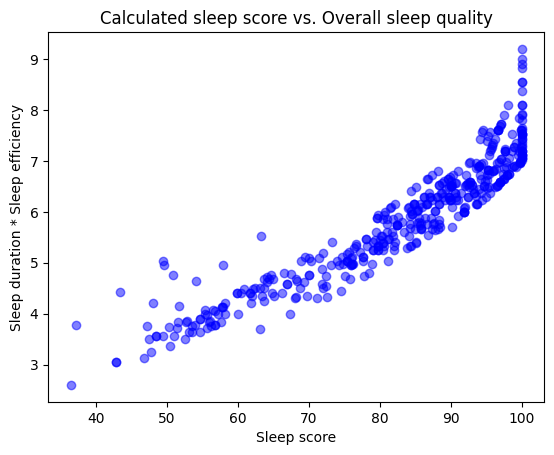

In [9]:
actual_sleep = efficiency_df["Sleep efficiency"] * efficiency_df["Sleep duration"]
plt.figure()
plt.scatter(efficiency_df["Sleep score"], actual_sleep, alpha=0.5, c="b")
plt.xlabel("Sleep score")
plt.ylabel("Sleep duration * Sleep efficiency")
plt.title("Calculated sleep score vs. Overall sleep quality")
plt.show()

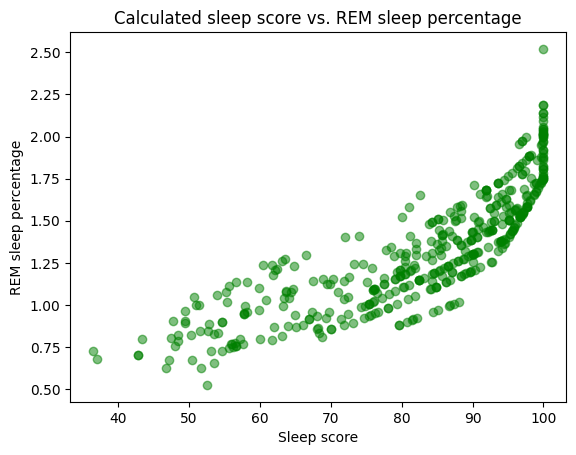

In [10]:
actual_rem = actual_sleep * efficiency_df["REM sleep percentage"] / 100
plt.figure()
plt.scatter(efficiency_df["Sleep score"], actual_rem, alpha=0.5, c="g")
plt.xlabel("Sleep score")
plt.ylabel("REM sleep percentage")
plt.title("Calculated sleep score vs. REM sleep percentage")
plt.show()

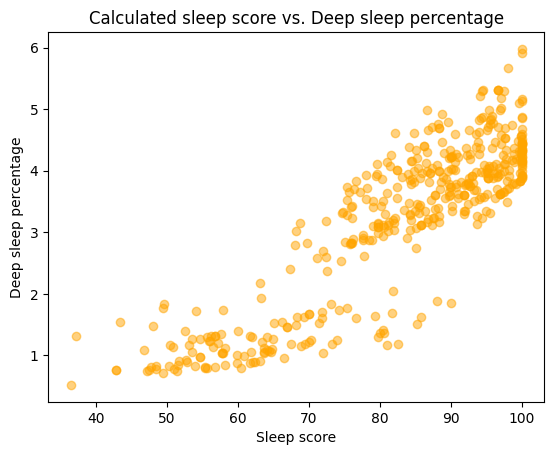

In [11]:
actual_deep = actual_sleep * efficiency_df["Deep sleep percentage"] / 100
plt.figure()
plt.scatter(efficiency_df["Sleep score"], actual_deep, alpha=0.5, c="orange")
plt.xlabel("Sleep score")
plt.ylabel("Deep sleep percentage")
plt.title("Calculated sleep score vs. Deep sleep percentage")
plt.show()

**Comments:**

Our calculated sleep score has a good correlation with the overall sleep quality, REM sleep percentage, and the deep sleep percentage. The range of our sleep score is from the mid-30s to 100, and most of the data points have a sleep score between 50 and 100. Based off the correlation between the sleep score and all three data values, and based off the spread of the different sleep score values, this seems like a pretty good metric that takes all different stages of sleep into account.

# Question 2
What are the relationships between a person’s characteristics (age, gender) and sleep score (calculated in the previous question), and is there a way to predict a person’s sleep score based on their age and gender?


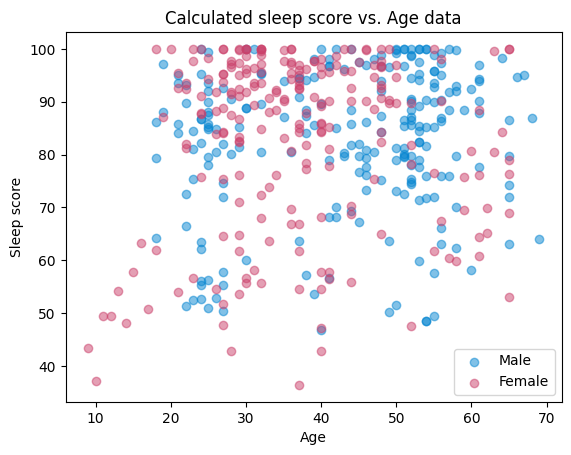

In [12]:
# Visualize the correlation between Age and Sleep score
efficiency_df_male = efficiency_df[efficiency_df["Sex"] == "Male"]
efficiency_df_female = efficiency_df[efficiency_df["Sex"] == "Female"]
plt.figure()
plt.scatter(efficiency_df_male["Age"], efficiency_df_male["Sleep score"], alpha=0.5, c="xkcd:cerulean", label="Male")
plt.scatter(efficiency_df_female["Age"], efficiency_df_female["Sleep score"], alpha=0.5, c="xkcd:dark pink", label="Female")
plt.xlabel("Age")
plt.ylabel("Sleep score")
plt.title("Calculated sleep score vs. Age data")
plt.legend()
plt.show()

**Comments on the correlation:**

There does not seem to be a strong correlation between age and the sleep score we calculated, which probably means that the model will not be very accurate.

In [13]:
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(efficiency_df, efficiency_df["Sleep score"], test_size=0.2, random_state=42)

In [14]:
# Baseline predictor - sample mean
y_pred_baseline = np.full(y_test.shape, y_train.mean())

In [15]:
# Make column transformer for characteristics
col_transformer_knn = make_column_transformer(
    (StandardScaler(), ["Age"]),
    (OneHotEncoder(), ["Sex"]),
    remainder="drop"
)

# Make a pipeline between the column transformer and a KNeighborsRegressor
pipeline_knn = make_pipeline(
    col_transformer_knn,
    KNeighborsRegressor()
)

# 10-fold Grid search with k range from 1-34 and all other hyperparameters tuned
grid_cv_knn = GridSearchCV(
    pipeline_knn,
    param_grid={"columntransformer__standardscaler__with_mean": [True, False],
                "columntransformer__standardscaler__with_std": [True, False],
                "kneighborsregressor__n_neighbors": range(1, 35),
                "kneighborsregressor__metric": ["euclidean", "manhattan"],
                "kneighborsregressor__weights": ["uniform", "distance"]},
    cv=10,
    scoring="neg_root_mean_squared_error"
)
# Train the grid search cross validation on the train datasets
grid_cv_knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Sex'])])),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'columntransformer__standardscaler__with_mean': [True,
                                                                          False],
                         'columntransformer__standardscaler__with_std': [True,
                                                                         False],
                         'kneighborsregressor__metric': ['euclidean',
                                                         'manhattan'],
                         'kneighborsregressor__n_neighbors': range(1, 35),
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_root_mean_squared_error')

In [16]:
# Make column transformer for characteristics
col_transformer_lr = make_column_transformer(
    (StandardScaler(), ["Age"]),
    (OneHotEncoder(), ["Sex"]),
    remainder="drop"
)

# Make a pipeline between the column transformer and a LinearRegression model
pipeline_lr = make_pipeline(
    col_transformer_lr,
    LinearRegression()
)

# 10-fold Grid search with all hyperparameters tuned
grid_cv_lr = GridSearchCV(
    pipeline_lr,
    param_grid={"columntransformer__standardscaler__with_mean": [True, False],
                "columntransformer__standardscaler__with_std": [True, False]},
    cv=10,
    scoring="neg_root_mean_squared_error"
)
# Train the grid search cross validation on the train datasets
grid_cv_lr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Sex'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'columntransformer__standardscaler__with_mean': [True,
                                                                          False],
                         'columntransformer__standardscaler__with_std': [True,
                                                                         False]},
             scoring='neg_root_mean_squared_error')

In [17]:
# Best parameters for KNN model
grid_cv_knn.best_params_

{'columntransformer__standardscaler__with_mean': True,
 'columntransformer__standardscaler__with_std': False,
 'kneighborsregressor__metric': 'manhattan',
 'kneighborsregressor__n_neighbors': 32,
 'kneighborsregressor__weights': 'uniform'}

In [18]:
# Train RMSE of best KNN model
print("KNN train RMSE")
-grid_cv_knn.best_score_

KNN train RMSE


14.889008323155526

In [19]:
# Best parameters for Linear Regression model
grid_cv_lr.best_params_

{'columntransformer__standardscaler__with_mean': True,
 'columntransformer__standardscaler__with_std': True}

In [20]:
print("Intercept:", grid_cv_lr.best_estimator_["linearregression"].intercept_)
pd.DataFrame(grid_cv_lr.best_estimator_["linearregression"].coef_, index=grid_cv_lr.best_estimator_[0].get_feature_names_out(), columns=["coefficient"])

Intercept: 82.59219512572486


,coefficient
standardscaler__Age,1.274442
onehotencoder__Sex_Female,0.538415
onehotencoder__Sex_Male,-0.538415


In [21]:
# Train RMSE of best Linear Regression model
print("Linear Regression train RMSE")
-grid_cv_lr.best_score_

Linear Regression train RMSE


15.019596656354343

In [22]:
y_pred_knn = grid_cv_knn.best_estimator_.predict(X_test)
y_pred_lr = grid_cv_lr.best_estimator_.predict(X_test)
print("KNN Validation RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("Linear Regression Validation RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Baseline Validation RMSE (Sample Mean):", np.sqrt(mean_squared_error(y_test, y_pred_baseline)))

KNN Validation RMSE: 14.74183640335684
Linear Regression Validation RMSE: 15.087918005069941
Baseline Validation RMSE (Sample Mean): 15.26828515073961


**Comments:**

These errors are not great because the sleep score generally ranges from around 50-100. With RMSE values at around 15, it shows that the predictors’ errors are spanning 30% of the actual range. The KNN model had both a lower train error and a lower validation error.

Based on the coefficients from the linear regression model, we can see that in general, a person who is older has a better sleep score, because its coefficient is positive. However, this correlation is not a very strong relationship given the variability in the data.  We can also see from these coefficients that females generally have a higher sleep score than males, because the coefficient for Female is positive and the coefficient for Male is negative.

We can also see here that the baseline RMSE is comparable to that of both the KNN and Linear Regression RMSE, showing that the features, age and gender, are not adding much value to the prediction, and hence, the model is not very useful in predicting sleep score.

In [23]:
# Make a dataframe of all the predicted values on the test set
y_pred_knn = pd.Series(y_pred_knn).set_axis(y_test.index)
y_pred_lr = pd.Series(y_pred_lr).set_axis(y_test.index)
df_sleep_score = pd.DataFrame([y_test, y_pred_knn, y_pred_lr], index=["Actual", "KNN Predicted", "LR Predicted"]).T

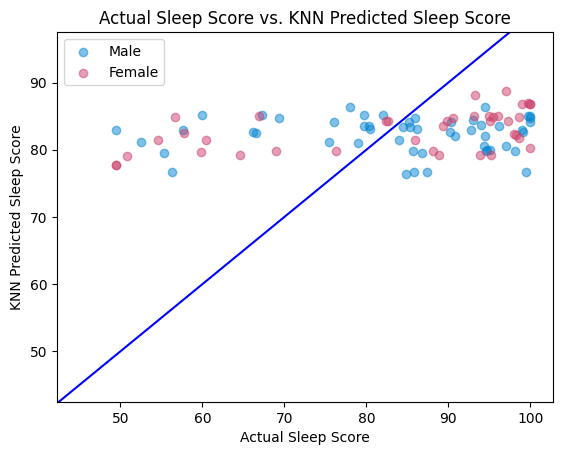

In [24]:
# Plot KNN Predictions
plt.figure()
plt.scatter(df_sleep_score[X_test["Sex"] == "Male"]["Actual"], df_sleep_score[X_test["Sex"] == "Male"]["KNN Predicted"], alpha=0.5, c="xkcd:cerulean", label="Male")
plt.scatter(df_sleep_score[X_test["Sex"] == "Female"]["Actual"],
df_sleep_score[X_test["Sex"] == "Female"]["KNN Predicted"], alpha=0.5, c="xkcd:dark pink", label="Female")
plt.axline((45, 45), (95, 95), c="blue")
plt.title("Actual Sleep Score vs. KNN Predicted Sleep Score")
plt.xlabel("Actual Sleep Score")
plt.ylabel("KNN Predicted Sleep Score")
plt.legend()
plt.show()

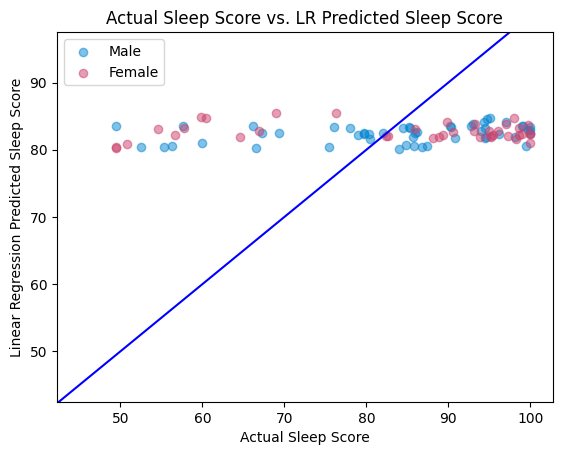

In [25]:
# Plot Linear Regression Predictions
plt.figure()
plt.scatter(df_sleep_score[X_test["Sex"] == "Male"]["Actual"], df_sleep_score[X_test["Sex"] == "Male"]["LR Predicted"], alpha=0.5, c="xkcd:cerulean", label="Male")
plt.scatter(df_sleep_score[X_test["Sex"] == "Female"]["Actual"],
df_sleep_score[X_test["Sex"] == "Female"]["LR Predicted"], alpha=0.5, c="xkcd:dark pink", label="Female")
plt.axline((45, 45), (95, 95), c="blue")
plt.title("Actual Sleep Score vs. LR Predicted Sleep Score")
plt.xlabel("Actual Sleep Score")
plt.ylabel("Linear Regression Predicted Sleep Score")
plt.legend()
plt.show()

**Comments:**

We can see from these graphs of the predictions that both the KNN and the Linear Regression model aren't very good at predicting the sleep score. They are both pretty much predicting a "flat" area, with a very small range of values. The KNN predictor seems to have a larger range, but it is still a very bad predictor.

It makes sense that these predictors are not very good, because as we saw in the EDA for this question, there is pretty much no correlation between age, gender, and sleep score. Looking at the graphs, and seeing that the actual range of the sleep scores in the test set is only from about 50 to 100, the validation errors don't seem as good anymore, because a RMSE of 15 would be around 30%.

# Question 3

Can we make a model predicting the sleep score based on one’s lifestyle (caffeine, alcohol, smoking, exercise)? Additionally, combining this analysis with the analysis from data set 1 (question 3), can we make a combined suggestion to change one’s lifestyle to improve sleep habits?

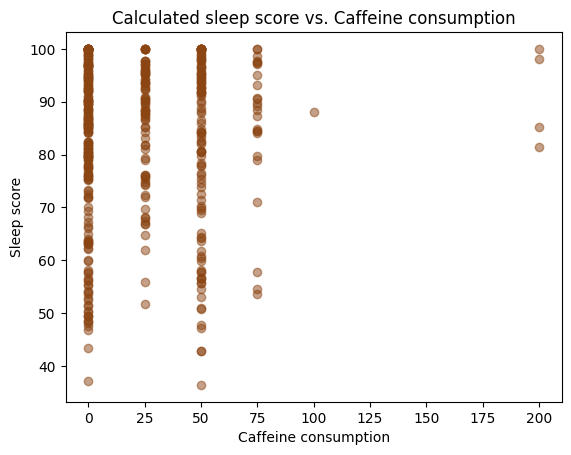

In [26]:
plt.figure()
plt.scatter(efficiency_df["Caffeine consumption"], efficiency_df["Sleep score"], alpha=0.5, c="saddlebrown")
plt.xlabel("Caffeine consumption")
plt.ylabel("Sleep score")
plt.title("Calculated sleep score vs. Caffeine consumption")
plt.show()

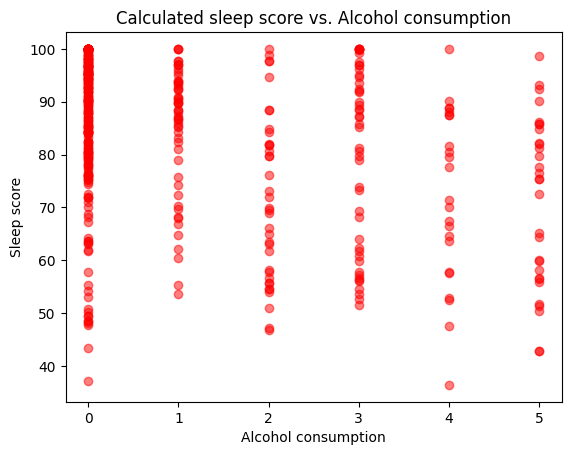

In [27]:
plt.figure()
plt.scatter(efficiency_df["Alcohol consumption"], efficiency_df["Sleep score"], alpha=0.5, c="red")
plt.xlabel("Alcohol consumption")
plt.ylabel("Sleep score")
plt.title("Calculated sleep score vs. Alcohol consumption")
plt.show()

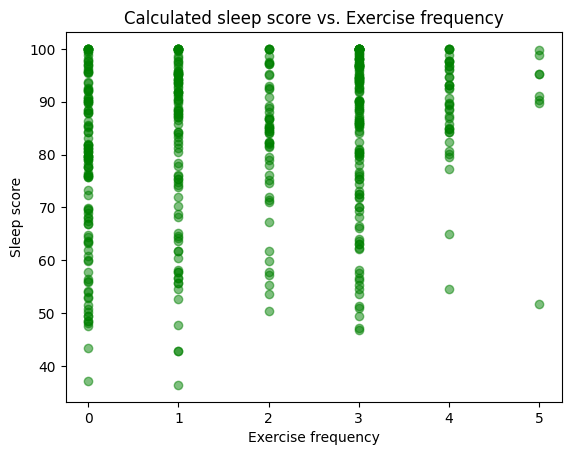

In [28]:
plt.figure()
plt.scatter(efficiency_df["Exercise frequency"], efficiency_df["Sleep score"], alpha=0.5, c="green")
plt.xlabel("Exercise frequency")
plt.ylabel("Sleep score")
plt.title("Calculated sleep score vs. Exercise frequency")
plt.show()

**Comments on EDA:**

We expected there to be a fairly strong negative correlation between caffeine consumption and the sleep score, but there seems to be no negative correlation at all based on the EDA. In fact, the correlation between alcohol consumption and sleep score seems stronger than the correlation between caffeine consumption and sleep scores based on its graph. There also does not seem to be a very strong correlation between exercise frequency and sleep score, and they have a weak positive correlation.

In [29]:
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(efficiency_df, efficiency_df["Sleep score"], test_size=0.2, random_state=42)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [30]:
# Baseline predictor - sample mean
y_pred_baseline = np.full(y_test.shape, y_train.mean())

In [31]:
# Make column transformer for lifestyle
col_transformer_knn = make_column_transformer(
    (StandardScaler(), ["Caffeine consumption", "Alcohol consumption", "Exercise frequency"]),
    (OneHotEncoder(), ["Smoking status"]),
    remainder="drop"
)

# Make a pipeline between the column transformer and a KNeighborsRegressor
pipeline_knn = make_pipeline(
    col_transformer_knn,
    KNeighborsRegressor()
)

# 10-fold Grid search with k range from 1-35 and all other hyperparameters tuned
grid_cv_knn = GridSearchCV(
    pipeline_knn,
    param_grid={"columntransformer__standardscaler__with_mean": [True, False],
                "columntransformer__standardscaler__with_std": [True, False],
                "kneighborsregressor__n_neighbors": range(1, 35),
                "kneighborsregressor__metric": ["euclidean", "manhattan"],
                "kneighborsregressor__weights": ["uniform", "distance"]},
    cv=10,
    scoring="neg_root_mean_squared_error"
)
# Train the grid search cross validation on the train datasets
grid_cv_knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Caffeine '
                                                                          'consumption',
                                                                          'Alcohol '
                                                                          'consumption',
                                                                          'Exercise '
                                                                          'frequency']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Smoking '
                                                                          'status'])])),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'columntransformer__standardscaler__with_mean': [True,
                                                                          False],
                         'columntransformer__standardscaler__with_std': [True,
                                                                         False],
                         'kneighborsregressor__metric': ['euclidean',
                                                         'manhattan'],
                         'kneighborsregressor__n_neighbors': range(1, 35),
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_root_mean_squared_error')

In [32]:
# Make column transformer for lifestyle
col_transformer_lr = make_column_transformer(
    (StandardScaler(), ["Caffeine consumption", "Alcohol consumption", "Exercise frequency"]),
    (OneHotEncoder(), ["Smoking status"]),
    remainder="drop"
)

# Make a pipeline between the column transformer and a LinearRegression model
pipeline_lr = make_pipeline(
    col_transformer_lr,
    LinearRegression()
)

# 10-fold Grid search with all hyperparameters tuned
grid_cv_lr = GridSearchCV(
    pipeline_lr,
    param_grid={"columntransformer__standardscaler__with_mean": [True, False],
                "columntransformer__standardscaler__with_std": [True, False]},
    cv=10,
    scoring="neg_root_mean_squared_error"
)
# Train the grid search cross validation on the train datasets
grid_cv_lr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Caffeine '
                                                                          'consumption',
                                                                          'Alcohol '
                                                                          'consumption',
                                                                          'Exercise '
                                                                          'frequency']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Smoking '
                                                                          'status'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'columntransformer__standardscaler__with_mean': [True,
                                                                          False],
                         'columntransformer__standardscaler__with_std': [True,
                                                                         False]},
             scoring='neg_root_mean_squared_error')

In [33]:
# Best parameters for KNN model
grid_cv_knn.best_params_

{'columntransformer__standardscaler__with_mean': False,
 'columntransformer__standardscaler__with_std': True,
 'kneighborsregressor__metric': 'manhattan',
 'kneighborsregressor__n_neighbors': 29,
 'kneighborsregressor__weights': 'uniform'}

In [34]:
# Train RMSE of best KNN model
print("KNN train RMSE")
-grid_cv_knn.best_score_

KNN train RMSE


13.189752266117278

In [35]:
# Best parameters for Linear Regression model
grid_cv_lr.best_params_

{'columntransformer__standardscaler__with_mean': True,
 'columntransformer__standardscaler__with_std': True}

In [36]:
print("Intercept:", grid_cv_lr.best_estimator_["linearregression"].intercept_)
pd.DataFrame(grid_cv_lr.best_estimator_["linearregression"].coef_, index=grid_cv_lr.best_estimator_[0].get_feature_names_out(), columns=["coefficient"])

Intercept: 81.17995078356878


,coefficient
standardscaler__Caffeine consumption,0.524776
standardscaler__Alcohol consumption,-4.827315
standardscaler__Exercise frequency,2.813750
onehotencoder__Smoking status_No,3.869669
onehotencoder__Smoking status_Yes,-3.869669


In [37]:
# Train RMSE of best Linear Regression model
print("Linear Regression train RMSE")
-grid_cv_lr.best_score_

Linear Regression train RMSE


13.491874254211712

In [38]:
y_pred_knn = grid_cv_knn.best_estimator_.predict(X_test)
y_pred_lr = grid_cv_lr.best_estimator_.predict(X_test)
print("KNN Validation RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("Linear Regression Validation RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Baseline Validation RMSE (Sample Mean):", np.sqrt(mean_squared_error(y_test, y_pred_baseline)))

KNN Validation RMSE: 12.979761789712958
Linear Regression Validation RMSE: 13.958574299020096
Baseline Validation RMSE (Sample Mean): 15.26828515073961


**Comments:**

Using the lifestyle habits data, the KNN model also has a lower train and validation RMSE than the linear regression model. The validation RMSE is, again, lower than the train RMSE, but this is likely due to the same reason as the previous problem - the range of the actual sleep scores in the test dataset is quite small - because the train and test datasets are split the same way.

Looking at the coefficients of the linear regression model, the signs of all of the coefficients make sense, except for the Caffeine consumption coefficient. We expected this coefficient to be negative, because consuming caffeine usually results in worse sleep. It makes sense that this value is smaller than the other values, because this column has a range of 0-200 compared to 0-5 for alcohol consumption and exercise frequency, and 0-1 for smoking status. We can see from the numbers that alcohol consumption has a stronger correlation with sleep score than exercise frequency because the absolute value of its coefficient is larger.

The baseline validation RMSE here is higher than both the models' validation RMSE here again, and it is higher by more than it was for question 2, which means that the models here trained on lifestyle data are better than the models trained on characteristics.


In [39]:
y_pred_knn = pd.Series(y_pred_knn).set_axis(y_test.index)
y_pred_lr = pd.Series(y_pred_lr).set_axis(y_test.index)
df_sleep_score = pd.DataFrame([y_test, y_pred_knn, y_pred_lr], index=["Actual", "KNN Predicted", "LR Predicted"]).T

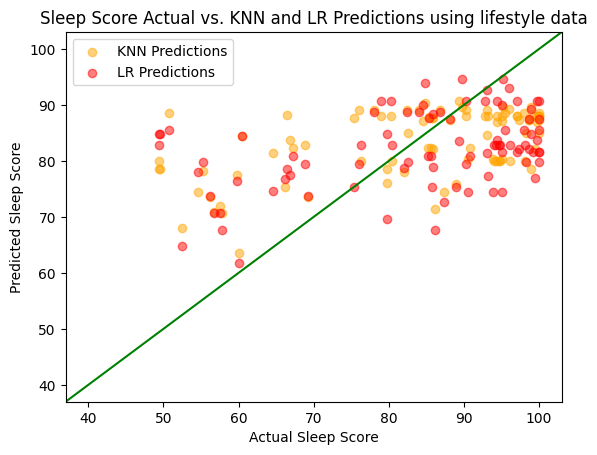

In [40]:
plt.figure()
plt.scatter(df_sleep_score["Actual"], df_sleep_score["KNN Predicted"], alpha=0.5, c="orange", label="KNN Predictions")
plt.scatter(df_sleep_score["Actual"], df_sleep_score["LR Predicted"], alpha=0.5, c="red", label="LR Predictions")
plt.axline((40, 40), (100, 100), c="green")
plt.title("Sleep Score Actual vs. KNN and LR Predictions using lifestyle data")
plt.xlabel("Actual Sleep Score")
plt.ylabel("Predicted Sleep Score")
plt.legend()
plt.show()

**Comments:**

From this graph, we can see that the KNN and linear regression models which take lifestyle habits into account instead of characteristics seem to be more accurate than the models from the previous problem. They seem to be predicting a larger range of the values and their predictions are closer to the line $y=x$ overall. The range of the sleep scores calculated by both models are now from ~48-80 instead of mostly being around 70. However, the models still aren't very good, and their validation RMSEs have not gone down by a lot.

It makes sense that these models trained on lifestyle data are more accurate than the models trained on characteristics, because as we saw in the EDA, there was at least a slight correlation between the data values and the sleep score. We thought that these models would improve the RMSE by much more than they did, but this was based on the expectation that these variables had a strong correlation with the sleep score. However, again, as we saw in the EDA, the correlations were not as strong as we expected.

In [41]:
print("Max Caffeine consumption:", efficiency_df["Caffeine consumption"].max())
print("Max Alcohol comsumption:", efficiency_df["Alcohol consumption"].max())
print("Max Exercise frequency:", efficiency_df["Exercise frequency"].max())

Max Caffeine consumption: 200.0
Max Alcohol comsumption: 5.0
Max Exercise frequency: 5.0


In [42]:
knn_model = grid_cv_knn.best_estimator_

In [43]:
possible_values = []
for caffeine in range(0, 201):
    for alcohol in range(0, 6):
        for exercise in range(0, 6):
            possible_values.append({"Caffeine consumption": caffeine, "Alcohol consumption": alcohol, "Exercise frequency": exercise, "Smoking status": "Yes"})
            possible_values.append({"Caffeine consumption": caffeine, "Alcohol consumption": alcohol, "Exercise frequency": exercise, "Smoking status": "No"})
df_lifestyle_all = pd.DataFrame(possible_values)

In [44]:
df_lifestyle_all["Predicted sleep score"] = knn_model.predict(df_lifestyle_all)

The below cell plots a random sample of 200 data points from a dataframe that contains all possible combinations of lifestyle values, with an x value of $Exercise - Alcohol - \frac{Caffiene}{40} - 5$(if smoking). The reason caffeine is divided by 40 is because its range is from 0-200, compared to 0-5 for most other variables. Smoking status is multiplied by 5 for the same reason.

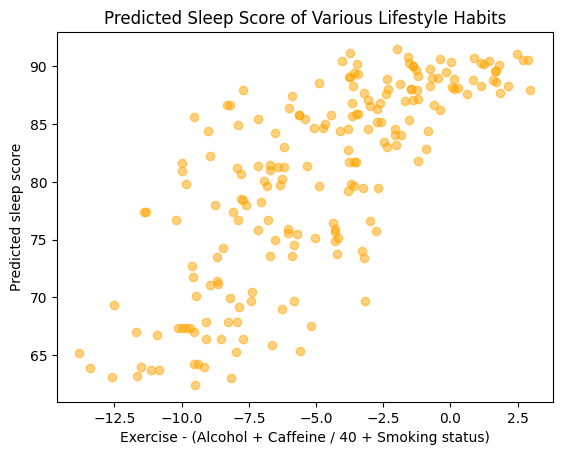

In [45]:
df_plot = df_lifestyle_all.sample(200)
plt.figure()
plt.scatter(df_plot["Exercise frequency"] - df_plot["Alcohol consumption"] - df_plot["Caffeine consumption"] / 40 - (df_plot["Smoking status"] == "Yes") * 5, df_plot["Predicted sleep score"], alpha=0.5, c="orange")
plt.xlabel("Exercise - (Alcohol + Caffeine / 40 + Smoking status)")
plt.ylabel("Predicted sleep score")
plt.title("Predicted Sleep Score of Various Lifestyle Habits")
plt.show()

The function below gives suggestions based on data of a single person. The first parameter is the data for the person, and the second parameter is the desired sleep score. The function first checks if the person smokes and suggests them to stop smoking. If their sleep score is still too low, then it decrements alcohol and caffeine consumption, and increments exercise frequency. It keeps doing this until the sleep score reaches the goal.

In [46]:
def suggest_lifestyle_improvements(row, sleep_score_goal):
    habits = row[["Caffeine consumption", "Alcohol consumption", "Exercise frequency", "Smoking status"]]
    habits_new = habits.copy()
    while df_lifestyle_all[(df_lifestyle_all["Caffeine consumption"] == habits_new["Caffeine consumption"]) & \
                           (df_lifestyle_all["Alcohol consumption"] == habits_new["Alcohol consumption"]) & \
                           (df_lifestyle_all["Exercise frequency"] == habits_new["Exercise frequency"]) & \
                           (df_lifestyle_all["Smoking status"] == habits_new["Smoking status"])]["Predicted sleep score"].values[0] < sleep_score_goal:
        if habits_new["Smoking status"] == "Yes":
            habits_new["Smoking status"] = "No"
        elif habits_new["Alcohol consumption"] >= habits_new["Caffeine consumption"] / 40 and habits_new["Alcohol consumption"] > 0:
            habits_new["Alcohol consumption"] -= 1
        elif habits_new["Caffeine consumption"] / 40 > habits_new["Alcohol consumption"] and habits_new["Caffeine consumption"] > 0:
            habits_new["Caffeine consumption"] -= 1
        if habits_new["Exercise frequency"] < 5:
            habits_new["Exercise frequency"] += 1
    if not habits_new.equals(habits):
        print(f"Here are some lifestyle changes that will help improve your sleep and help your sleep score reach {sleep_score_goal}:")
    else:
        print("Your sleep is good already, no changes need to be made!")
    if habits["Smoking status"] == "Yes" and habits_new["Smoking status"] == "No":
        print("Stop smoking.")
    if habits["Alcohol consumption"] - habits_new["Alcohol consumption"] > 0:
        print(f"Decrease alcohol consumption by {habits['Alcohol consumption'] - habits_new['Alcohol consumption']} oz.")
    if habits["Caffeine consumption"] - habits_new["Caffeine consumption"] > 0:
        print(f"Decrease caffeine consumption by {habits['Caffeine consumption'] - habits_new['Caffeine consumption']} mg.")
    if habits_new["Exercise frequency"] - habits["Exercise frequency"] > 0:
        print(f"Exercise {habits_new['Exercise frequency'] - habits['Exercise frequency']} more times per week.")

The loop below tests what the function suggests to a random sample of five data points from the dataset of all possible lifestyle habit values.

In [47]:
for row in df_lifestyle_all.sample(5).index:
    print(df_lifestyle_all.iloc[row])
    suggest_lifestyle_improvements(df_lifestyle_all.iloc[row], 76)
    print()

Caffeine consumption           172
Alcohol consumption              3
Exercise frequency               1
Smoking status                  No
Predicted sleep score    79.735074
Name: 12423, dtype: object
Your sleep is good already, no changes need to be made!

Caffeine consumption            12
Alcohol consumption              1
Exercise frequency               5
Smoking status                  No
Predicted sleep score    89.177512
Name: 887, dtype: object
Your sleep is good already, no changes need to be made!

Caffeine consumption            61
Alcohol consumption              3
Exercise frequency               1
Smoking status                 Yes
Predicted sleep score    71.170739
Name: 4430, dtype: object
Here are some lifestyle changes that will help improve your sleep and help your sleep score reach 76:
Stop smoking.
Exercise 1 more times per week.

Caffeine consumption           100
Alcohol consumption              2
Exercise frequency               4
Smoking status               